In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# 📦 Install & import
!pip install dask --quiet

%matplotlib inline

import os
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm.notebook import tqdm
from google.colab import drive

In [ ]:
dataset_paths = {
    "2class": "/content/drive/MyDrive/CICIoT2023/2class/",
    "8class": "/content/drive/MyDrive/CICIoT2023/8class/",
    "34class": "/content/drive/MyDrive/CICIoT2023/34class/"
}

save_dir = "/content/drive/MyDrive/CICIoT2023/Feature_Reduced"
os.makedirs(save_dir, exist_ok=True)

In [ ]:
def plot_heatmap(df, title, filename, max_features=100):
    df_features = df.drop(columns=['label'])

    # 🧼 Clean NaNs/Infs and limit to first N features for clarity
    df_features = df_features.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
    if df_features.shape[1] > max_features:
        df_features = df_features.iloc[:, :max_features]

    corr_matrix = df_features.corr().abs()

    plt.figure(figsize=(16, 14), dpi=300)  # 🔍 High-res, bigger
    sns.heatmap(
        corr_matrix,
        cmap="coolwarm",
        annot=True,        # ✅ Show values inside cells
        fmt=".2f",
        square=True,
        linewidths=0.5,
        linecolor='gray',
        cbar_kws={"shrink": 0.7},
        xticklabels=True,
        yticklabels=True
    )
    plt.title(title, fontsize=16)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=8)

    save_path = f"{save_dir}/{filename}"
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)  # 🖼️ High DPI
    plt.show()
    plt.close()
    print(f"📸 Heatmap saved to: {save_path}")

In [ ]:
# 🧠 Feature reduction function
def reduce_features_by_pcc(dataset_name, parquet_folder_path, threshold=0.9):
    print(f"\n📁 Processing {dataset_name}...")

    # Load & compute with Dask
    ddf = dd.read_parquet(parquet_folder_path)
    df = ddf.compute()

    if 'label' not in df.columns:
        raise KeyError("'label' column not found!")

    # Clean and drop NaN/infinite values
    df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

    df_features = df.drop(columns=['label'])
    corr_matrix = df_features.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Drop features based on threshold
    to_drop = [col for col in upper_triangle.columns if any(upper_triangle[col] > threshold)]
    print(f"🧹 Dropping {len(to_drop)} features")

    # Retain label and uncorrelated features
    reduced_df = df[[col for col in df.columns if col not in to_drop]]

    # Save reduced
    save_path = f"{save_dir}/{dataset_name}_reduced.parquet"
    reduced_df.to_parquet(save_path)
    print(f"✅ Saved reduced dataset to: {save_path}")
    print(f"→ Final shape: {reduced_df.shape}")

📊 Generating BEFORE heatmap for 34-class...


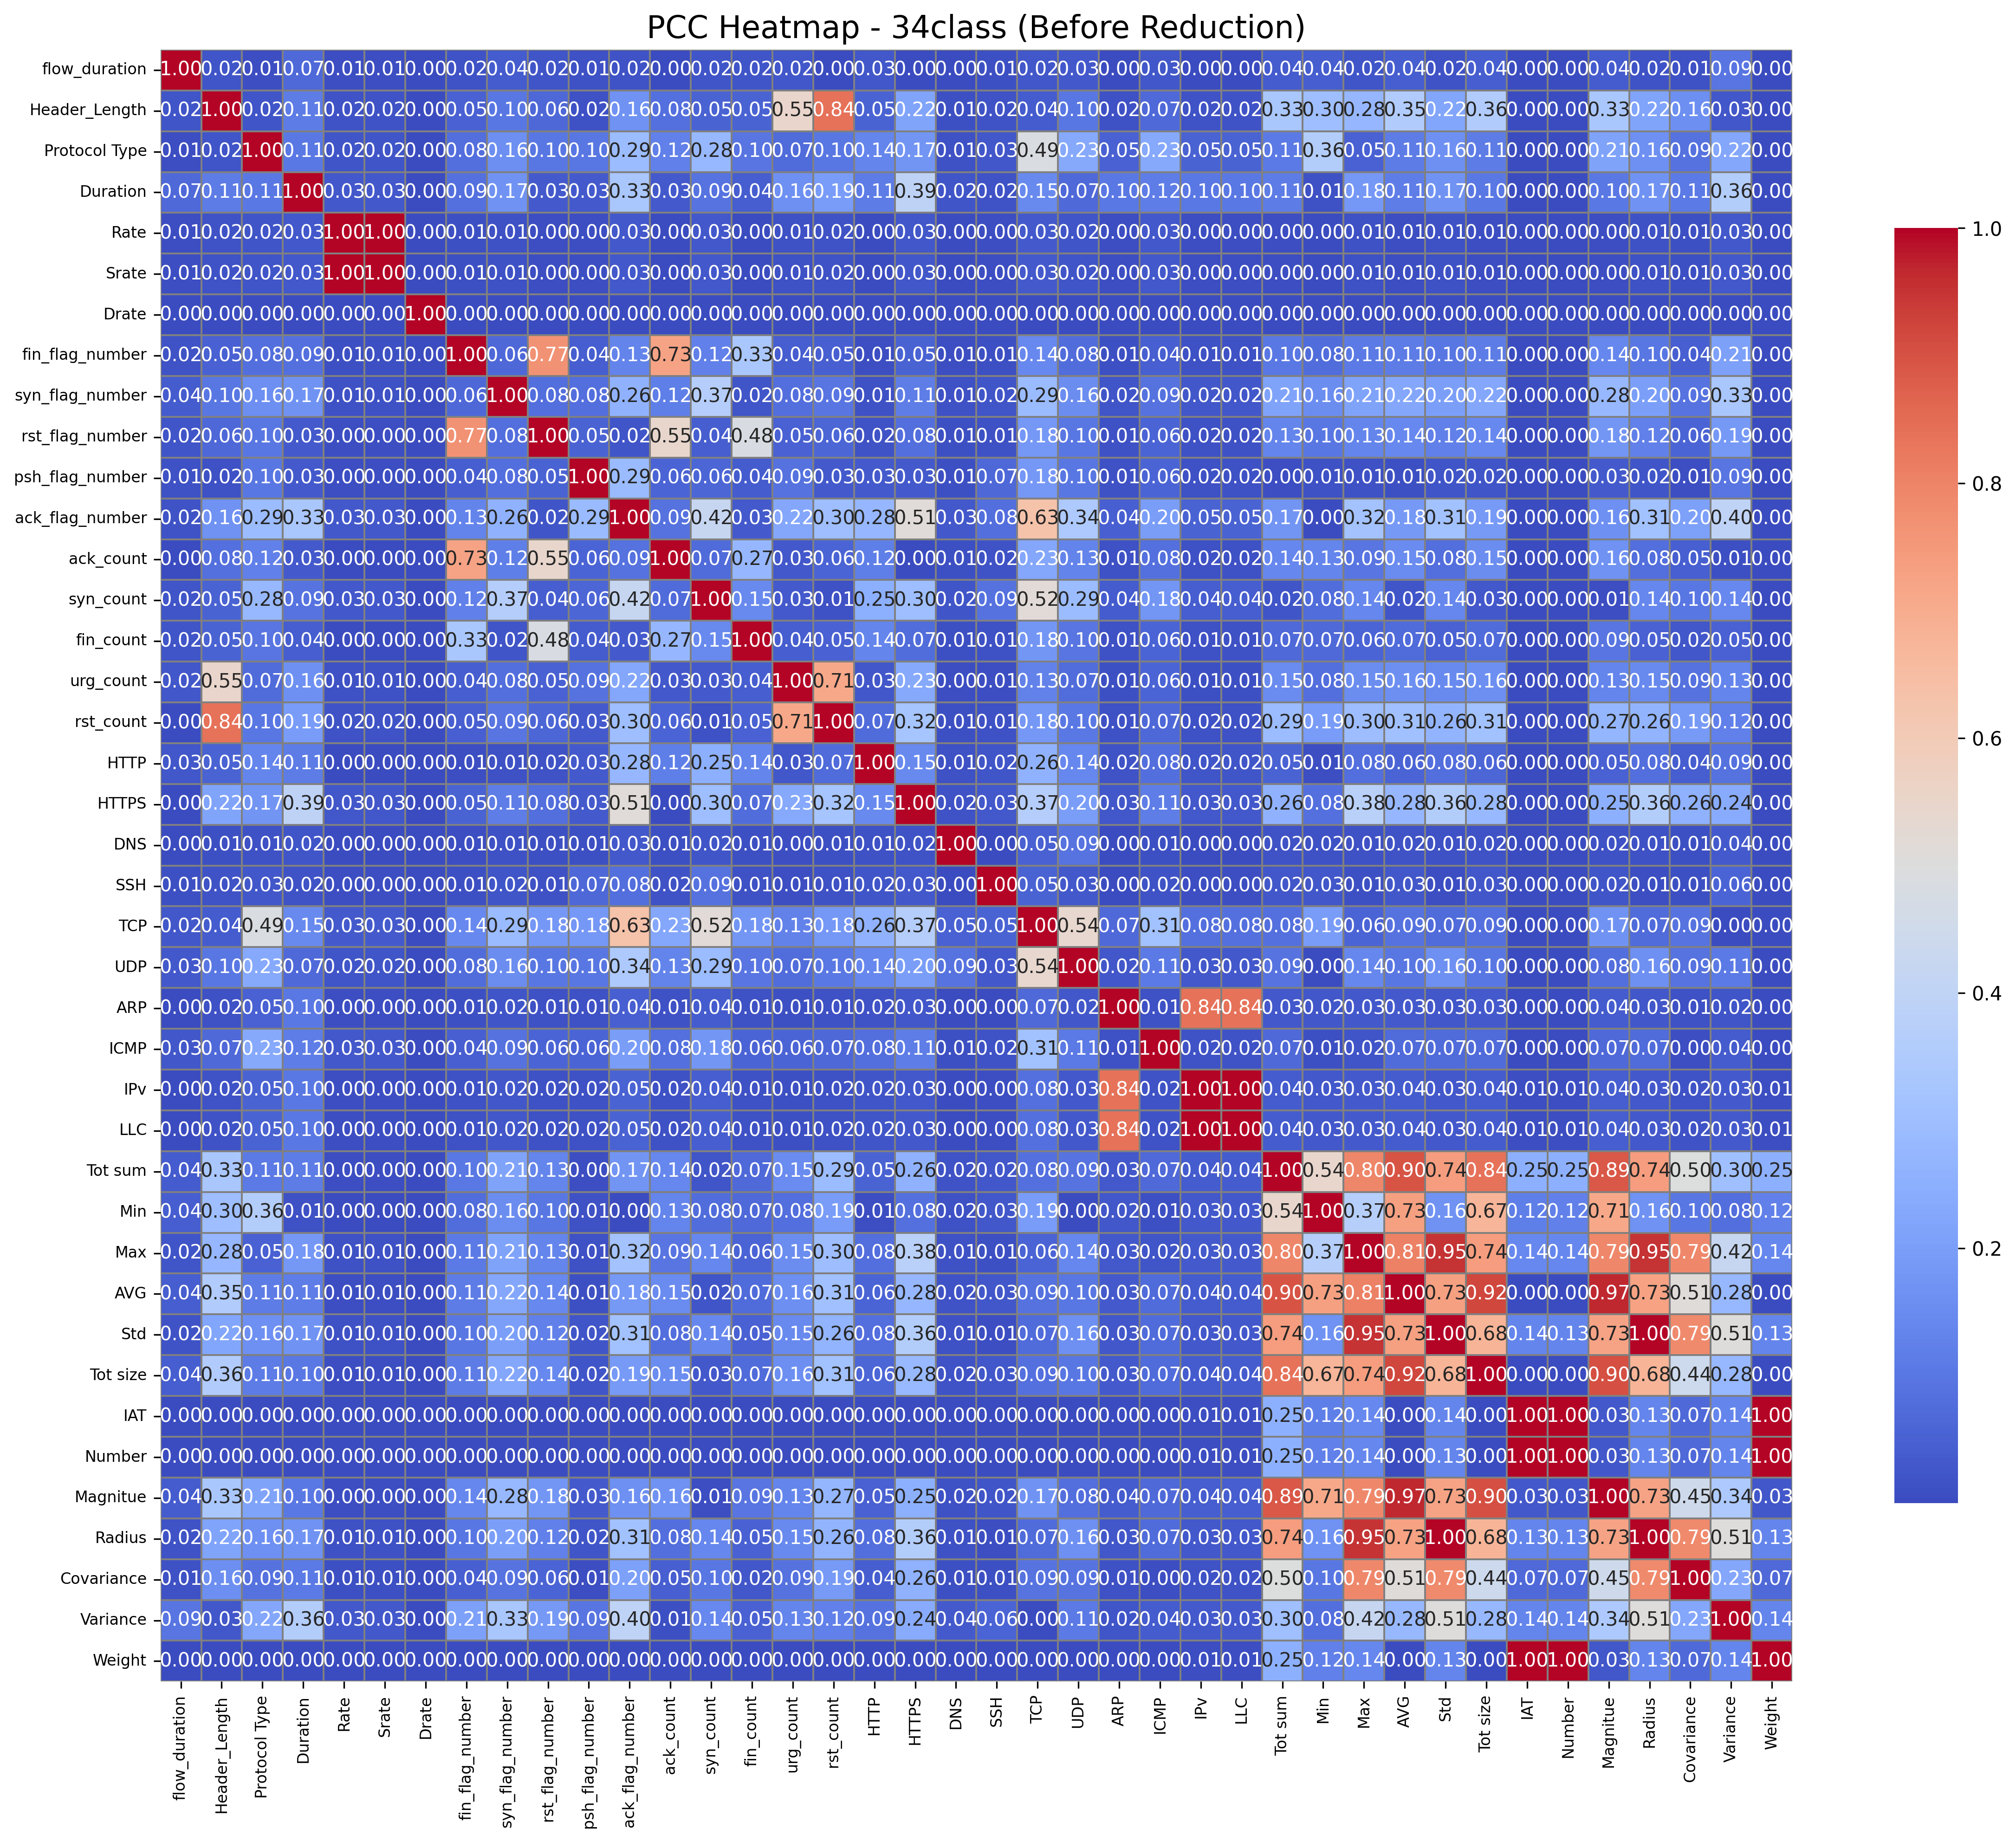

📸 Heatmap saved to: /content/drive/MyDrive/CICIoT2023/Feature_Reduced/34class_pcc_before.png


In [ ]:
# 🔍 STEP 1: Load and show BEFORE heatmap (34-class)
ddf_34 = dd.read_parquet(dataset_paths["34class"])
df_34 = ddf_34.compute()
df_34 = df_34.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

print("📊 Generating BEFORE heatmap for 34-class...")
plot_heatmap(df_34, "PCC Heatmap - 34class (Before Reduction)", "34class_pcc_before.png")

In [ ]:
# 🔁 STEP 2: Feature reduction for all 3 class types
for name, path in tqdm(dataset_paths.items(), desc="🔄 Reducing features"):
    reduce_features_by_pcc(name, path)

🔄 Reducing features:   0%|          | 0/3 [00:00<?, ?it/s]


📁 Processing 2class...
🧹 Dropping 10 features
✅ Saved reduced dataset to: /content/drive/MyDrive/CICIoT2023/Feature_Reduced/2class_reduced.parquet
→ Final shape: (16900, 31)

📁 Processing 8class...
🧹 Dropping 7 features
✅ Saved reduced dataset to: /content/drive/MyDrive/CICIoT2023/Feature_Reduced/8class_reduced.parquet
→ Final shape: (246022, 34)

📁 Processing 34class...
🧹 Dropping 8 features
✅ Saved reduced dataset to: /content/drive/MyDrive/CICIoT2023/Feature_Reduced/34class_reduced.parquet
→ Final shape: (2844140, 33)


📊 Generating AFTER heatmap for 34-class...


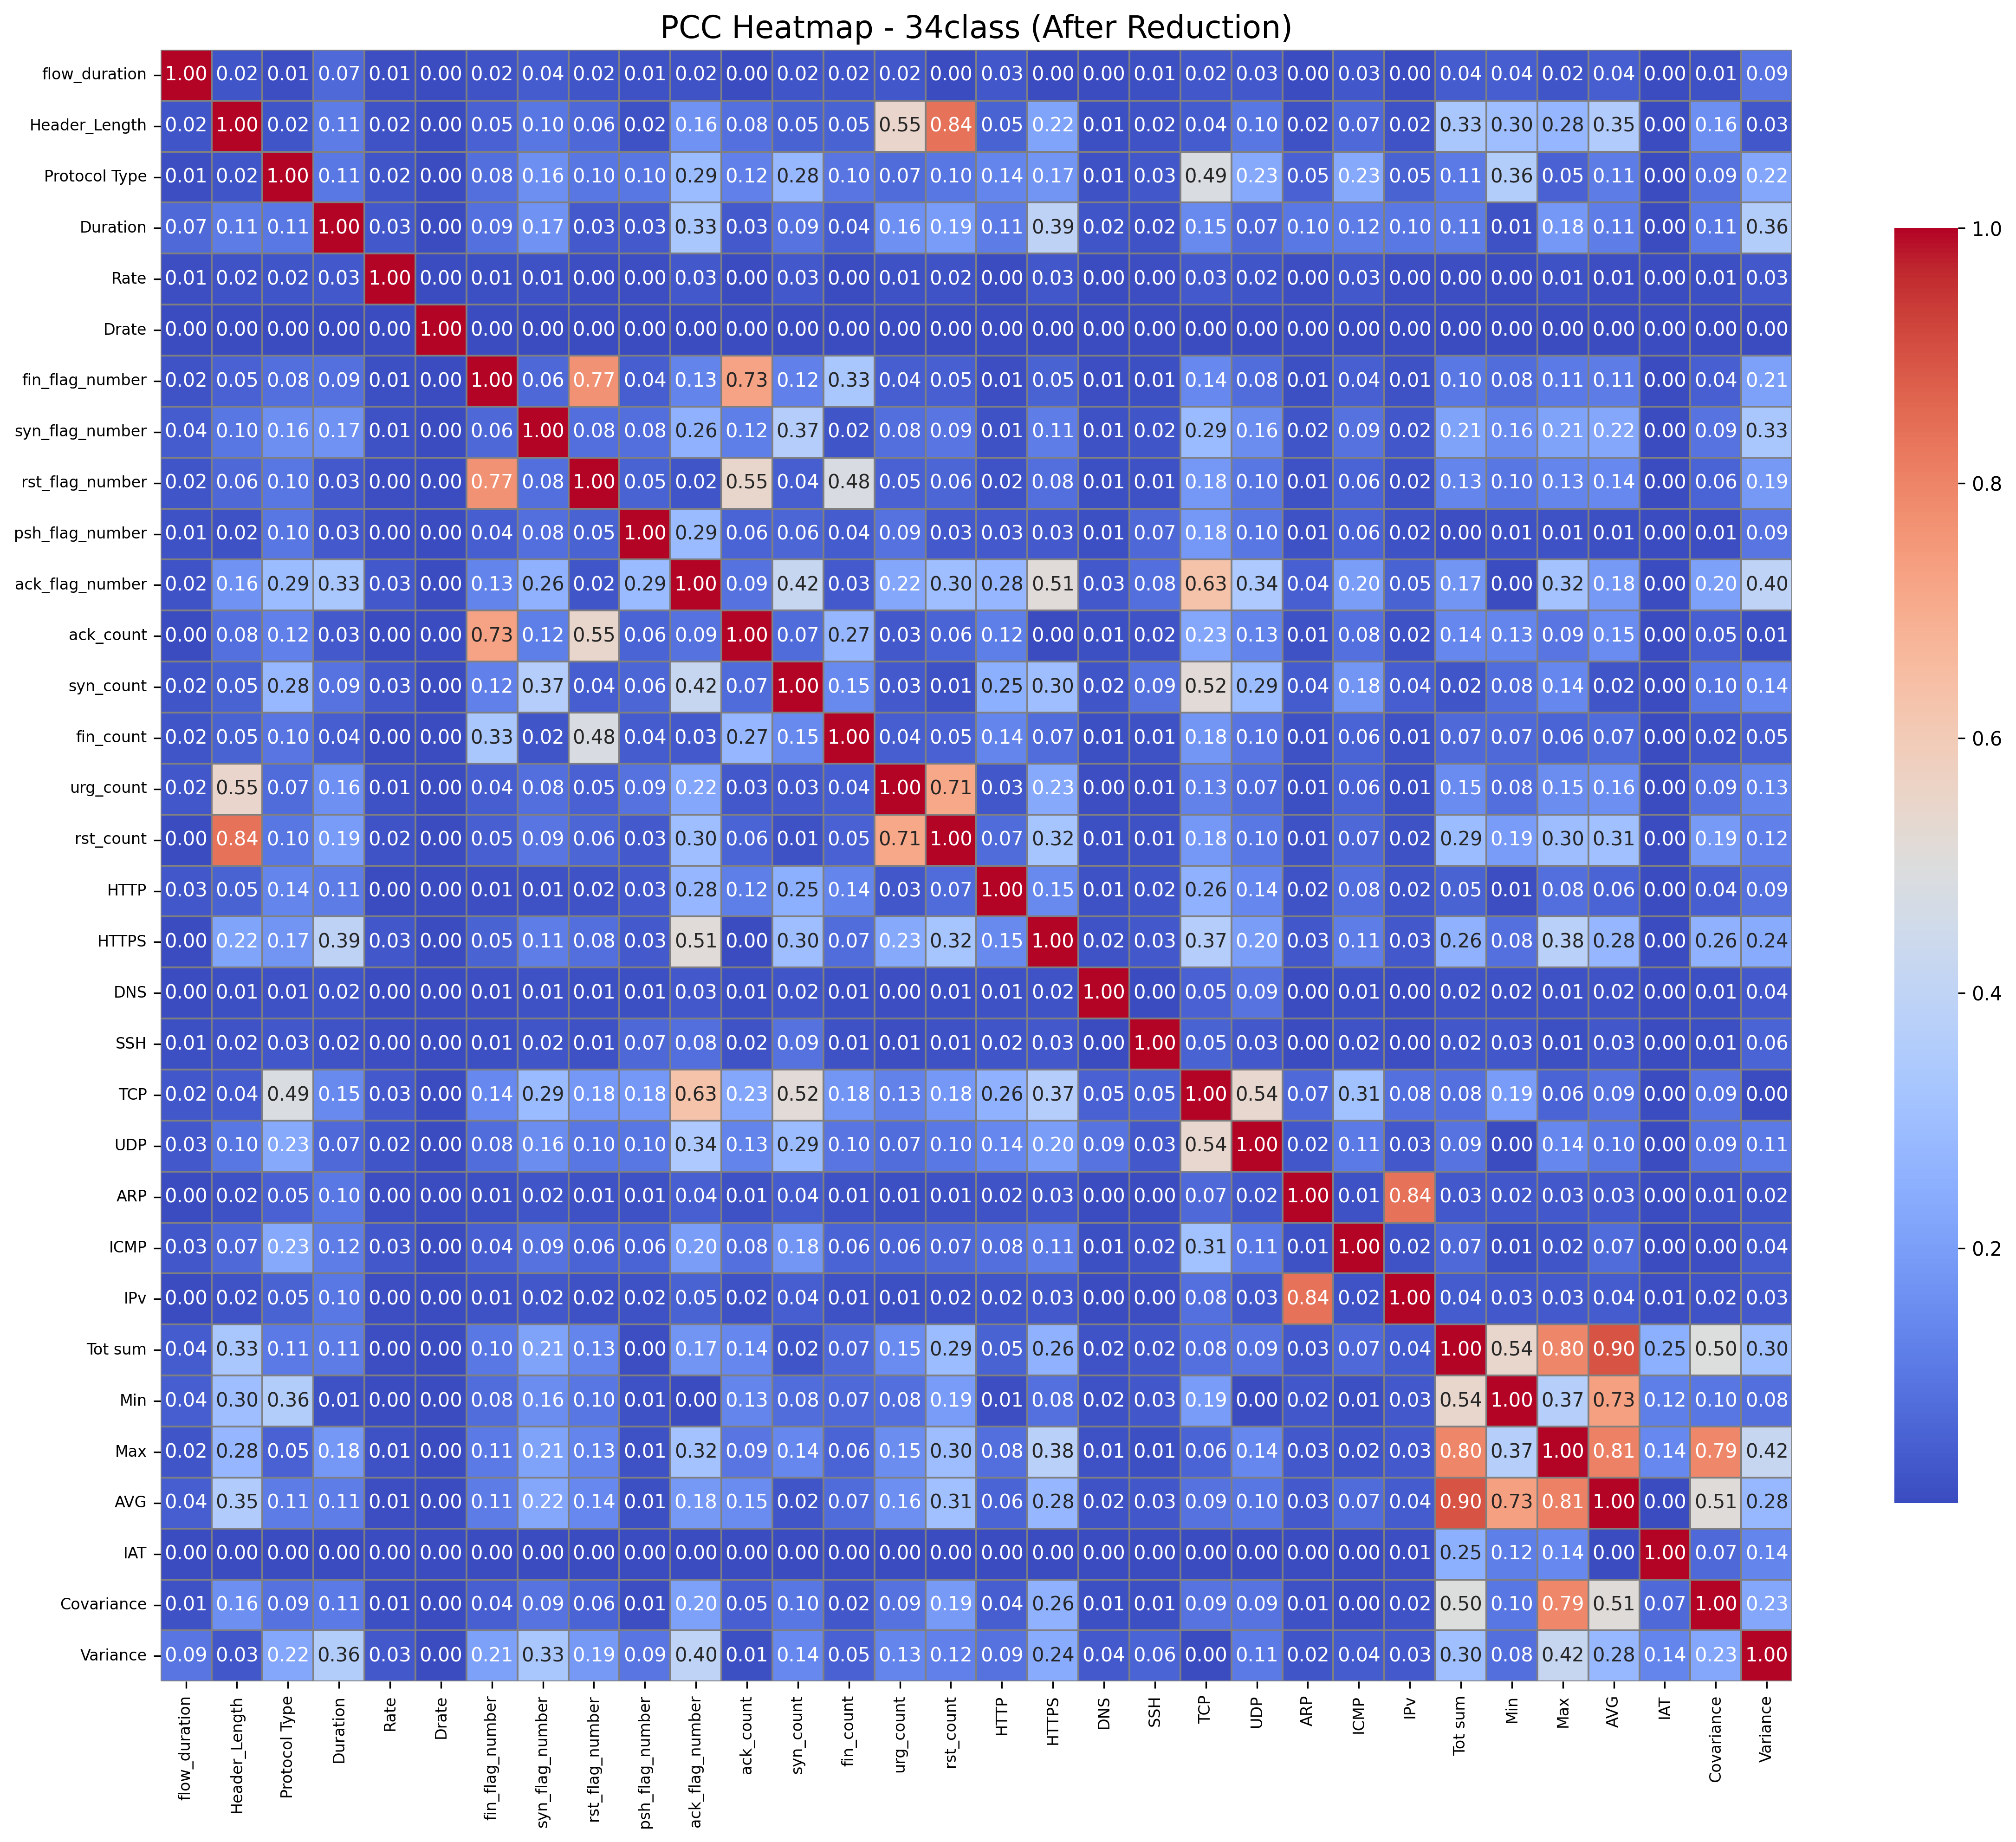

📸 Heatmap saved to: /content/drive/MyDrive/CICIoT2023/Feature_Reduced/34class_pcc_after.png


In [ ]:
# 🔍 STEP 3: Load and show AFTER heatmap (34-class)
reduced_34_path = f"{save_dir}/34class_reduced.parquet"
df_34_reduced = pd.read_parquet(reduced_34_path)

print("📊 Generating AFTER heatmap for 34-class...")
plot_heatmap(df_34_reduced, "PCC Heatmap - 34class (After Reduction)", "34class_pcc_after.png")